In [2]:
import csv
import cv2
import os
import pickle

import pandas as pd
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image, ImageFont

from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.applications import vgg16, inception_v3, resnet, xception
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image as image_method
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import visualkeras

In [3]:
RANDOM_STATE = 42

In [4]:
def load_dataset(target_size):
    x, y = [], []
    base_path = "./data/images/"

    for dir in os.listdir(base_path):
        for image in os.listdir(os.path.join(base_path, dir)):
            image_path = os.path.join(base_path, dir, image)
            image = Image.open(image_path)
            rgb_image = image.copy().convert("RGB")
            x.append(np.array(rgb_image.resize(target_size), dtype=np.uint8))
            y.append(dir)

    return x, y

In [5]:
target_size = (224, 224)

In [6]:
metadata = pd.read_csv("./data/metadata.csv")
meta_filter = metadata[["Channel", "Category"]]
meta_filter = meta_filter.drop_duplicates()
meta_dict = meta_filter.set_index("Channel")["Category"].to_dict()

In [7]:
x, y = load_dataset(target_size)

class: Abroad in Japan


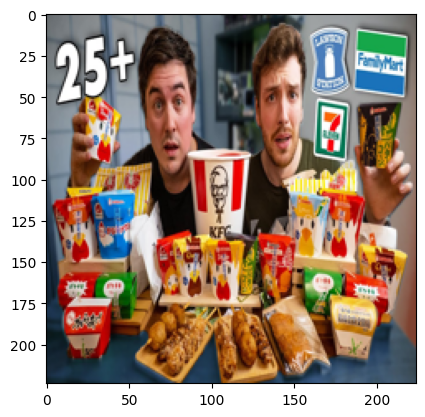

In [8]:
plt.imshow(x[100])
print(f"class: {y[100]}")

In [9]:
print(set(meta_dict.values()))

coarse_dict = {
    'automotive': ['Automobile,Comedy', 'Automobile'],
    'blog': ['Blog,Comedy', 'Blog,Entertainment', 'Blog', 'Blog,Science'],
    'comedy': ['Comedy', 'Comedy,Informative', 'Comedy,Entertainment'],
    'entertainment': ['Entertainment,Blog', 'Entertainment,Comedy', 'Entertainment'],
    'food': ['Food', 'Food,Entertainment'],
    'information': ['Science', 'News', 'Informative'],
    'technology': ['VideoGames', 'Tech,Comedy', 'Tech,News', 'Tech,Informative', 'Tech'],
}

{'Blog', 'Blog,Comedy', 'Comedy', 'Entertainment,Comedy', 'Tech,Informative', 'Automobile,Comedy', 'Tech,News', 'Blog,Science', 'Tech', 'Informative', 'Tech,Comedy', 'Science', 'Comedy,Informative', 'News', 'Food,Entertainment', 'Entertainment', 'Entertainment,Blog', 'Blog,Entertainment', 'Comedy,Entertainment', 'Automobile', 'VideoGames', 'Food'}


In [10]:
y_fine = [meta_dict[item] for item in y]

y_coarse = []
for item in y_fine:
    for key, value in coarse_dict.items():
        if item in value:
            y_coarse.append(key)

In [11]:
print(f"Length Fine: {len(y_fine)} ---  Length Coarse: {len(y_coarse)}")

Length Fine: 2303 ---  Length Coarse: 2303


In [12]:
for i, item in enumerate(y_fine):
    print(f"Fine: {item} --- Coarse: {y_coarse[i]}")

Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Science --- Coarse: information
Fine: Scienc

In [13]:
set_y_coarse = set(y_coarse)
count_dict = {}
for item in set_y_coarse:
    count_dict[item] = y_coarse.count(item)

print(count_dict)

{'blog': 234, 'automotive': 261, 'comedy': 174, 'food': 268, 'entertainment': 164, 'information': 689, 'technology': 513}


In [14]:
with open("./results/Data/CSV/distribution_v2.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Category", "Count"])
    for category, occurence in count_dict.items():
        writer.writerow([category, occurence])

In [15]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_coarse)
y_one_hot = to_categorical(y_encoded)

In [15]:
with open('le_classes_coarse.pkl', 'wb') as f:
    pickle.dump(le.classes_, f)

In [16]:
sm = SMOTE(random_state=RANDOM_STATE)
x = np.array(x)
n_samples, width, height, n_channels = x.shape

x_flat = x.reshape(n_samples, -1)

x, y_one_hot = sm.fit_resample(x_flat, y_one_hot)
x = x.reshape(-1, width, height, n_channels)

In [17]:
value_distribution = pd.DataFrame([le.classes_[np.argmax(line)] for line in y_one_hot])
print(value_distribution.value_counts())

automotive       689
blog             689
comedy           689
entertainment    689
food             689
information      689
technology       689
Name: count, dtype: int64


In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y_one_hot, test_size=0.2, random_state=RANDOM_STATE)
x_train = np.array(x_train)
x_test = np.array(x_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=RANDOM_STATE)
x_train = np.array(x_train)
x_val = np.array(x_val)

print(f"Train Size: {len(y_train)} --- Validation Size: {len(y_val)} --- Test Size: {len(y_test)}")

Train Size: 3086 --- Validation Size: 772 --- Test Size: 965


In [19]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [20]:
train_generator = train_datagen.flow(
    x_train, 
    y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    x_val,
    y_val,
    batch_size=32,
    shuffle=False
)

test_generator = test_datagen.flow(
    x_test, 
    y_test,
    batch_size=32,
    shuffle=False
)

In [21]:
accuracy_dict = {}

In [22]:
def plot_class_accuracies(class_accuracies):
    fig, ax = plt.subplots()
    ax.bar(le.classes_, class_accuracies, color="#ff4122")
    ax.set_xticklabels(le.classes_, rotation=90)
    ax.set_xlabel("Class")
    ax.set_ylabel("Accuracy")
    plt.show()

# Custom Model Grid Search

In [20]:
def create_custom_cnn(n_filter_1, n_filter_2, kernel_size, pool_size, n_hidden, activation):
    model = Sequential()
    model.add(Conv2D(n_filter_1, kernel_size=kernel_size, activation="relu", input_shape=target_size+(3,)))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Conv2D(n_filter_2, kernel_size=kernel_size, activation="relu"))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(n_hidden, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(len(le.classes_), activation=activation))
    model.compile(optimizer=Adam(learning_rate=1e-03), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [21]:
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

model = KerasClassifier(build_fn=create_custom_cnn)
param_grid = {
    'n_filter_1': [32, 64],
    'n_filter_2': [32, 64],
    'kernel_size': [3, 5],
    'pool_size': [2, 3],
    'n_hidden': [64, 128],
    'activation': ['sigmoid', 'softmax']
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=3)
grid_result = grid.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stop, reduce_lr])

print(f'Best Parameters: {grid_result.best_params_}')
print(f'Best Accuracy: {grid_result.best_score_:.2f}')

c:\Users\Dominik Hahn\Anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  after removing the cwd from sys.path.


Fitting 3 folds for each of 64 candidates, totalling 192 fits
Epoch 1/20
62/62 [==============================] - 5s 19ms/step - loss: 115.8884 - accuracy: 0.2076 - val_loss: 1.8121 - val_accuracy: 0.2986 - lr: 0.0010
Epoch 2/20
62/62 [==============================] - 1s 14ms/step - loss: 1.4751 - accuracy: 0.4964 - val_loss: 1.8476 - val_accuracy: 0.3608 - lr: 0.0010
Epoch 3/20
62/62 [==============================] - 1s 15ms/step - loss: 0.8346 - accuracy: 0.7472 - val_loss: 1.7991 - val_accuracy: 0.4405 - lr: 0.0010
Epoch 4/20
62/62 [==============================] - 1s 15ms/step - loss: 0.4996 - accuracy: 0.8741 - val_loss: 2.2075 - val_accuracy: 0.4338 - lr: 0.0010
Epoch 5/20
62/62 [==============================] - 1s 15ms/step - loss: 0.3295 - accuracy: 0.9234 - val_loss: 2.3968 - val_accuracy: 0.4500 - lr: 0.0010
Epoch 6/20
62/62 [==============================] - 1s 14ms/step - loss: 0.2387 - accuracy: 0.9528 - val_loss: 2.5436 - val_accuracy: 0.4459 - lr: 0.0010
Epoch 7/20
6

# Custom Model

In [23]:
custom_model = Sequential()
custom_model.add(Conv2D(32, kernel_size=3, activation="relu", input_shape=target_size+(3,)))
custom_model.add(MaxPooling2D(pool_size=3))
custom_model.add(Conv2D(64, kernel_size=3, activation="relu", name='last_conv'))
custom_model.add(MaxPooling2D(pool_size=3))
custom_model.add(Flatten())
custom_model.add(Dense(128, activation="relu"))
custom_model.add(Dropout(0.3))
custom_model.add(Dense(len(le.classes_), activation="softmax"))

custom_model.compile(optimizer=Adam(learning_rate=1e-03), loss="categorical_crossentropy", metrics=["accuracy"])

Epoch 1/100
97/97 [==============================] - 23s 190ms/step - loss: 2.0141 - accuracy: 0.2035 - val_loss: 1.7975 - val_accuracy: 0.3225 - lr: 0.0010
Epoch 2/100
97/97 [==============================] - 18s 183ms/step - loss: 1.7296 - accuracy: 0.3331 - val_loss: 1.5232 - val_accuracy: 0.4378 - lr: 0.0010
Epoch 3/100
97/97 [==============================] - 18s 183ms/step - loss: 1.5548 - accuracy: 0.3995 - val_loss: 1.4027 - val_accuracy: 0.4922 - lr: 0.0010
Epoch 4/100
97/97 [==============================] - 18s 183ms/step - loss: 1.3932 - accuracy: 0.4861 - val_loss: 1.2693 - val_accuracy: 0.5505 - lr: 0.0010
Epoch 5/100
97/97 [==============================] - 18s 184ms/step - loss: 1.2367 - accuracy: 0.5418 - val_loss: 1.1671 - val_accuracy: 0.5803 - lr: 0.0010
Epoch 6/100
97/97 [==============================] - 18s 183ms/step - loss: 1.1297 - accuracy: 0.6043 - val_loss: 1.1202 - val_accuracy: 0.6114 - lr: 0.0010
Epoch 7/100
97/97 [==============================] - 18s 1

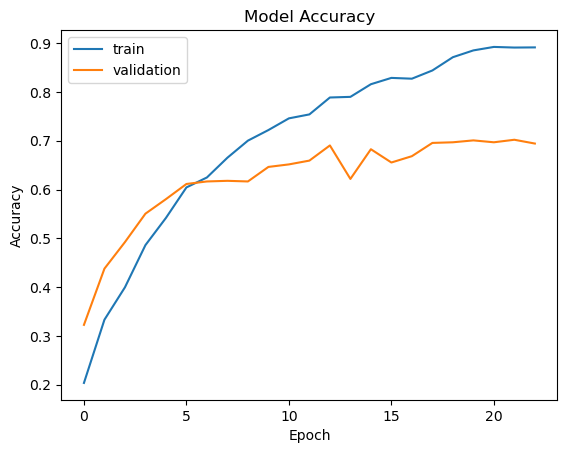

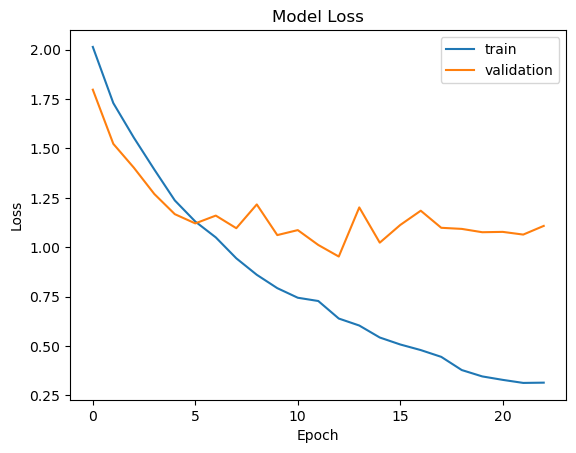

In [22]:
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

history = custom_model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr],
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

31/31 [==============================] - 1s 21ms/step
Accuracy of 68.81%


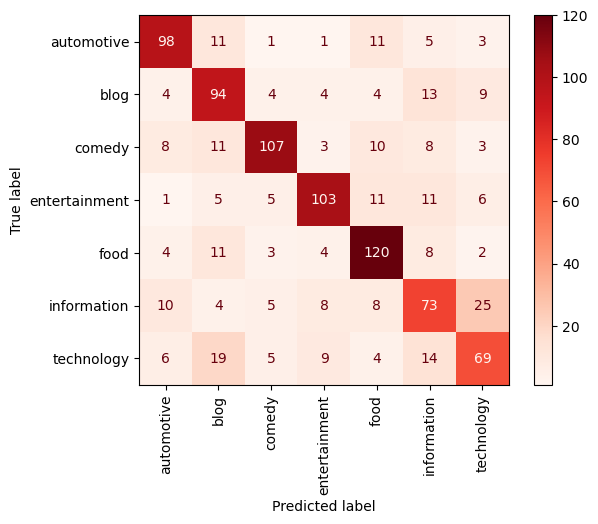

In [62]:
pred = custom_model.predict(test_generator)
predictions = np.argmax(pred, axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)
acc = round(accuracy_score(np.argmax(y_test, axis=1), predictions)*100,2)
print(f"Accuracy of {acc}%")
cm_display = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
cm_display.plot(cmap="Reds", xticks_rotation=90)

C:\Users\Dominik Hahn\AppData\Local\Temp\ipykernel_7236\962454562.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(le.classes_, rotation=90)


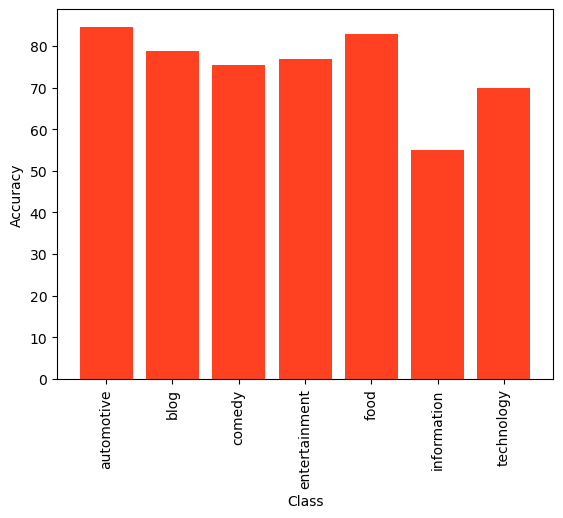

In [95]:
class_count = cm.sum(axis=1)
class_accuracy = np.diag(cm) / class_count
class_accuracy = [round(class_acc * 100, 2) for class_acc in class_accuracy]

weighted_accuracy = round(np.sum(np.array(class_accuracy) * class_count) / np.sum(class_count),2)
accuracy_dict["custom"] = [round(np.mean(class_accuracy),2), weighted_accuracy]

plot_class_accuracies(class_accuracy)

In [24]:
custom_model.save("./saved_models/v2/custom.h5")

# Transfer Learning Grid Search

In [25]:
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

## VGG16

In [23]:
def create_vgg16_model(optimizer, init, n_hidden_1, n_hidden_2, activation):
    base_model = vgg16.VGG16(weights="imagenet", include_top=False, input_shape=target_size+(3,))

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(n_hidden_1, activation="relu", kernel_initializer=init))
    model.add(Dense(n_hidden_2, activation="relu", kernel_initializer=init))
    model.add(Dense(len(le.classes_), activation=activation, kernel_initializer=init))

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    return model

In [26]:
model = KerasClassifier(build_fn=create_vgg16_model)

param_grid = {
    'optimizer': ['rmsprop', 'adam'],
    'init': ['glorot_uniform', 'normal'],
    'n_hidden_1': [64, 128],
    'n_hidden_2': [64, 128],
    'activation': ['sigmoid', 'softmax'],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=3)
grid_result = grid.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stop, reduce_lr])

print(f'Best Parameters: {grid_result.best_params_}')
print(f'Best Accuracy: {grid_result.best_score_:.2f}')

c:\Users\Dominik Hahn\Anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Epoch 1/20
62/62 [==============================] - 14s 75ms/step - loss: 2.9764 - accuracy: 0.3822 - val_loss: 0.5117 - val_accuracy: 0.3486 - lr: 0.0010
Epoch 2/20
62/62 [==============================] - 3s 46ms/step - loss: 0.4497 - accuracy: 0.5548 - val_loss: 0.3329 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 3/20
62/62 [==============================] - 3s 45ms/step - loss: 0.2855 - accuracy: 0.6929 - val_loss: 0.5779 - val_accuracy: 0.5149 - lr: 0.0010
Epoch 4/20
62/62 [==============================] - 3s 44ms/step - loss: 0.1936 - accuracy: 0.7904 - val_loss: 0.3452 - val_accuracy: 0.6770 - lr: 0.0010
Epoch 5/20
62/62 [==============================] - 3s 45ms/step - loss: 0.1562 - accuracy: 0.8452 - val_loss: 0.3059 - val_accuracy: 0.6757 - lr: 0.0010
Epoch 6/20
62/62 [==============================] - 3s 44ms/step - loss: 0.1292 - accuracy: 0.8751 - val_loss: 0.3904 - val_accuracy: 0.6649 - lr: 0.0010
Epoch 7/20
62/

## InceptionV3

In [27]:
def create_inceptionv3_model(optimizer, init, n_hidden_1, n_hidden_2, activation):
    base_model = inception_v3.InceptionV3(weights="imagenet", include_top=False, input_shape=target_size+(3,))

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(n_hidden_1, activation="relu", kernel_initializer=init))
    model.add(Dense(n_hidden_2, activation="relu", kernel_initializer=init))
    model.add(Dense(len(le.classes_), activation=activation, kernel_initializer=init))

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    return model

In [28]:
model = KerasClassifier(build_fn=create_inceptionv3_model)

param_grid = {
    'optimizer': ['rmsprop', 'adam'],
    'init': ['glorot_uniform', 'normal'],
    'n_hidden_1': [64, 128],
    'n_hidden_2': [64, 128],
    'activation': ['sigmoid', 'softmax'],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=3)
grid_result = grid.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stop, reduce_lr])

print(f'Best Parameters: {grid_result.best_params_}')
print(f'Best Accuracy: {grid_result.best_score_:.2f}')

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\Dominik Hahn\Anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


Epoch 1/20
62/62 [==============================] - 7s 69ms/step - loss: 13.4405 - accuracy: 0.1624 - val_loss: 4.3928 - val_accuracy: 0.1568 - lr: 0.0010
Epoch 2/20
62/62 [==============================] - 3s 42ms/step - loss: 1.2021 - accuracy: 0.1675 - val_loss: 0.6559 - val_accuracy: 0.1459 - lr: 0.0010
Epoch 3/20
62/62 [==============================] - 3s 42ms/step - loss: 0.7281 - accuracy: 0.1487 - val_loss: 0.6029 - val_accuracy: 0.1581 - lr: 0.0010
Epoch 4/20
62/62 [==============================] - 3s 42ms/step - loss: 0.5770 - accuracy: 0.1604 - val_loss: 0.5366 - val_accuracy: 0.1581 - lr: 0.0010
Epoch 5/20
62/62 [==============================] - 3s 42ms/step - loss: 0.5143 - accuracy: 0.1563 - val_loss: 0.4739 - val_accuracy: 0.1514 - lr: 0.0010
Epoch 6/20
62/62 [==============================] - 3s 42ms/step - loss: 0.4479 - accuracy: 0.1477 - val_loss: 0.4268 - val_accuracy: 0.1500 - lr: 0.0010
Epoch 7/20
62/62 [==============================] - 3s 42ms/step - loss: 0.

## ResNet50

In [29]:
def create_resnet50_model(optimizer, init, n_hidden_1, n_hidden_2, activation):
    base_model = resnet.ResNet50(weights="imagenet", include_top=False, input_shape=target_size+(3,))

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(n_hidden_1, activation="relu", kernel_initializer=init))
    model.add(Dense(n_hidden_2, activation="relu", kernel_initializer=init))
    model.add(Dense(len(le.classes_), activation=activation, kernel_initializer=init))

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    return model

In [30]:
model = KerasClassifier(build_fn=create_resnet50_model)

param_grid = {
    'optimizer': ['rmsprop', 'adam'],
    'init': ['glorot_uniform', 'normal'],
    'n_hidden_1': [64, 128],
    'n_hidden_2': [64, 128],
    'activation': ['sigmoid', 'softmax'],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=3)
grid_result = grid.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stop, reduce_lr])

print(f'Best Parameters: {grid_result.best_params_}')
print(f'Best Accuracy: {grid_result.best_score_:.2f}')

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\Dominik Hahn\Anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


Epoch 1/20
62/62 [==============================] - 7s 64ms/step - loss: 1.7459 - accuracy: 0.3259 - val_loss: 0.6015 - val_accuracy: 0.3919 - lr: 0.0010
Epoch 2/20
62/62 [==============================] - 3s 48ms/step - loss: 0.4537 - accuracy: 0.5807 - val_loss: 0.5809 - val_accuracy: 0.4662 - lr: 0.0010
Epoch 3/20
62/62 [==============================] - 3s 46ms/step - loss: 0.2465 - accuracy: 0.7477 - val_loss: 0.6245 - val_accuracy: 0.5081 - lr: 0.0010
Epoch 4/20
62/62 [==============================] - 3s 47ms/step - loss: 0.1386 - accuracy: 0.8802 - val_loss: 0.2970 - val_accuracy: 0.7243 - lr: 0.0010
Epoch 5/20
62/62 [==============================] - 3s 46ms/step - loss: 0.0920 - accuracy: 0.9213 - val_loss: 0.4259 - val_accuracy: 0.6824 - lr: 0.0010
Epoch 6/20
62/62 [==============================] - 3s 46ms/step - loss: 0.0403 - accuracy: 0.9695 - val_loss: 0.3407 - val_accuracy: 0.7284 - lr: 0.0010
Epoch 7/20
62/62 [==============================] - 3s 46ms/step - loss: 0.0

## Xception

In [31]:
def create_xception_model(optimizer, init, n_hidden_1, n_hidden_2, activation):
    base_model = xception.Xception(weights="imagenet", include_top=False, input_shape=target_size+(3,))

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(n_hidden_1, activation="relu", kernel_initializer=init))
    model.add(Dense(n_hidden_2, activation="relu", kernel_initializer=init))
    model.add(Dense(len(le.classes_), activation=activation, kernel_initializer=init))

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    return model

In [32]:
model = KerasClassifier(build_fn=create_xception_model)

param_grid = {
    'optimizer': ['rmsprop', 'adam'],
    'init': ['glorot_uniform', 'normal'],
    'n_hidden_1': [64, 128],
    'n_hidden_2': [64, 128],
    'activation': ['sigmoid', 'softmax'],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=3)
grid_result = grid.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stop, reduce_lr])

print(f'Best Parameters: {grid_result.best_params_}')
print(f'Best Accuracy: {grid_result.best_score_:.2f}')

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\Dominik Hahn\Anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


Epoch 1/20
62/62 [==============================] - 7s 80ms/step - loss: 5.5052 - accuracy: 0.1716 - val_loss: 0.5558 - val_accuracy: 0.1459 - lr: 0.0010
Epoch 2/20
62/62 [==============================] - 4s 60ms/step - loss: 0.5941 - accuracy: 0.1523 - val_loss: 0.4440 - val_accuracy: 0.1405 - lr: 0.0010
Epoch 3/20
62/62 [==============================] - 4s 61ms/step - loss: 0.4856 - accuracy: 0.1416 - val_loss: 0.5782 - val_accuracy: 0.1405 - lr: 0.0010
Epoch 4/20
62/62 [==============================] - 4s 60ms/step - loss: 0.4747 - accuracy: 0.1477 - val_loss: 0.4607 - val_accuracy: 0.1351 - lr: 0.0010
Epoch 5/20
62/62 [==============================] - 4s 62ms/step - loss: 0.4579 - accuracy: 0.1629 - val_loss: 0.4575 - val_accuracy: 0.1446 - lr: 0.0010
Epoch 6/20
62/62 [==============================] - 4s 63ms/step - loss: 0.4623 - accuracy: 0.1467 - val_loss: 0.4341 - val_accuracy: 0.1514 - lr: 0.0010
Epoch 7/20
62/62 [==============================] - 4s 60ms/step - loss: 0.4

# Transfer Learning application

VGG16: {'activation': 'sigmoid', 'init': 'glorot_uniform', 'n_hidden_1': 128, 'n_hidden_2': 64, 'optimizer': 'adam'} 0.75  
InceptionV3: {'activation': 'softmax', 'init': 'glorot_uniform', 'n_hidden_1': 64, 'n_hidden_2': 64, 'optimizer': 'adam'} 0.43  
ResNet50: {'activation': 'sigmoid', 'init': 'glorot_uniform', 'n_hidden_1': 64, 'n_hidden_2': 64, 'optimizer': 'adam'} 0.76  
Xception: {'activation': 'sigmoid', 'init': 'glorot_uniform', 'n_hidden_1': 128, 'n_hidden_2': 64, 'optimizer': 'adam'} 0.52

In [24]:
model_vgg_16 = vgg16.VGG16(weights="imagenet", include_top=False, input_shape=target_size+(3,))
model_inception_v3 = inception_v3.InceptionV3(weights="imagenet", include_top=False, input_shape=target_size+(3,))
model_resnet_50 = resnet.ResNet50(weights="imagenet", include_top=False, input_shape=target_size+(3,))
model_xception = xception.Xception(weights="imagenet", include_top=False, input_shape=target_size+(3,))

In [25]:
model_dict = {
    'vgg_16': model_vgg_16,
    'inception_v3': model_inception_v3,
    'resnet_50': model_resnet_50,
    'xception': model_xception
}

for key, value in model_dict.items():
    for layer in value.layers:
        layer.trainable = False

In [26]:
dropout = 0.2
learning_rate = 1e-03
epochs = 50

early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)


In [28]:
for key, value in model_dict.items():
    model = Sequential()
    model.add(value)
    model.add(Flatten())
    if key == "vgg_16" or key == "xception":
        model.add(Dense(128, activation="relu"))
    else:
        model.add(Dense(64, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(64, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    if key == "inception_v3":
        model.add(Dense(len(le.classes_), activation="softmax"))
    else:
        model.add(Dense(len(le.classes_), activation="sigmoid"))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])

    model_dict[key] = model

In [71]:
history_dict = {}

for key, value in model_dict.items():    
    print(f"[INFO] --- Training of {key}")

    early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

    history = value.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[early_stop, reduce_lr],
    )

    history_dict[key] = history

[INFO] --- Training of vgg_16
Epoch 1/50
97/97 [==============================] - 20s 193ms/step - loss: 1.4480 - accuracy: 0.4893 - val_loss: 2.1474 - val_accuracy: 0.3705 - lr: 0.0010
Epoch 2/50
97/97 [==============================] - 18s 183ms/step - loss: 0.8947 - accuracy: 0.6831 - val_loss: 1.1095 - val_accuracy: 0.6477 - lr: 0.0010
Epoch 3/50
97/97 [==============================] - 18s 183ms/step - loss: 0.7070 - accuracy: 0.7586 - val_loss: 0.8769 - val_accuracy: 0.6995 - lr: 0.0010
Epoch 4/50
97/97 [==============================] - 18s 183ms/step - loss: 0.5543 - accuracy: 0.8114 - val_loss: 0.9544 - val_accuracy: 0.6969 - lr: 0.0010
Epoch 5/50
97/97 [==============================] - 18s 183ms/step - loss: 0.4895 - accuracy: 0.8338 - val_loss: 0.8573 - val_accuracy: 0.7137 - lr: 0.0010
Epoch 6/50
97/97 [==============================] - 18s 186ms/step - loss: 0.4142 - accuracy: 0.8587 - val_loss: 0.8447 - val_accuracy: 0.7176 - lr: 0.0010
Epoch 7/50
97/97 [================

History for vgg_16


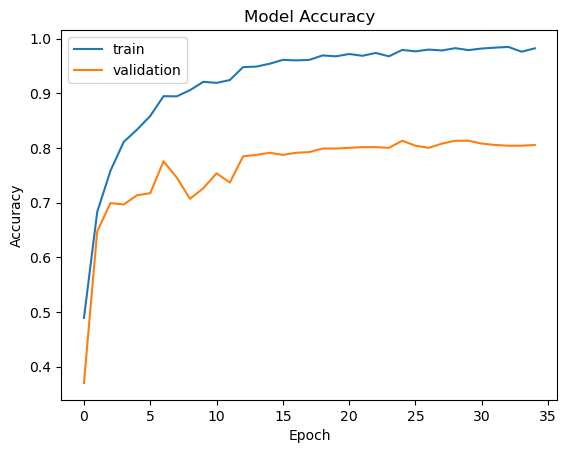

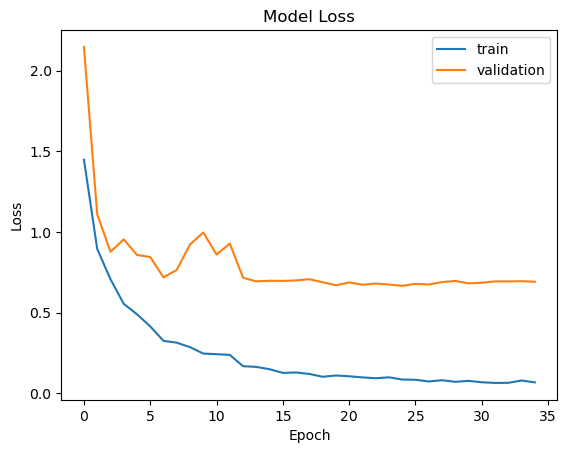

History for inception_v3


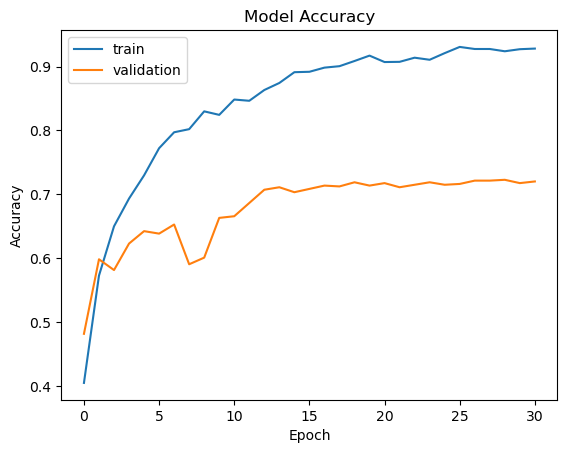

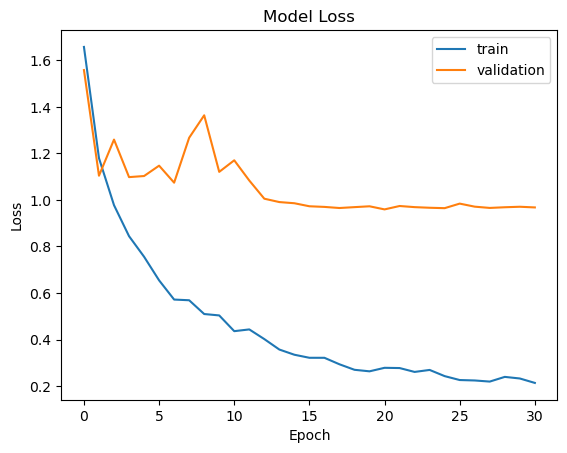

History for resnet_50


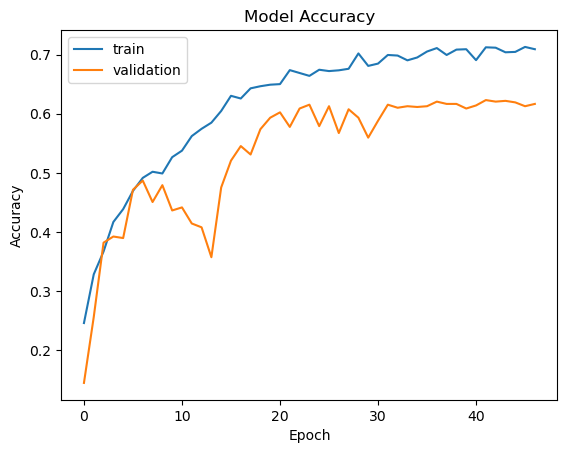

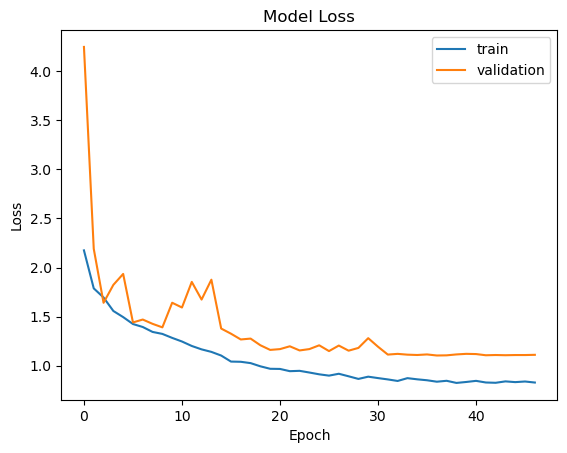

History for xception


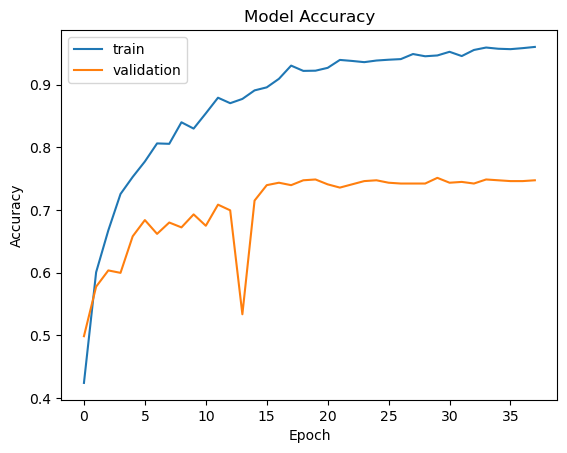

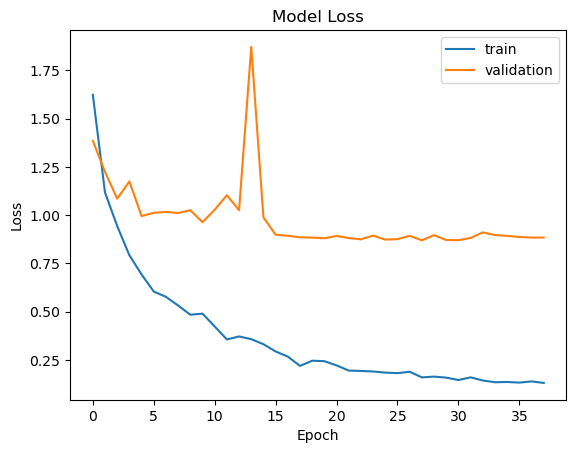

In [72]:
for key, history in history_dict.items():
    print(f"History for {key}")
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # plot training and validation loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

31/31 [==============================] - 2s 51ms/step
Accuracy of 81.66%
31/31 [==============================] - 1s 33ms/step
Accuracy of 73.68%
31/31 [==============================] - 1s 41ms/step
Accuracy of 61.04%
31/31 [==============================] - 1s 40ms/step
Accuracy of 74.92%


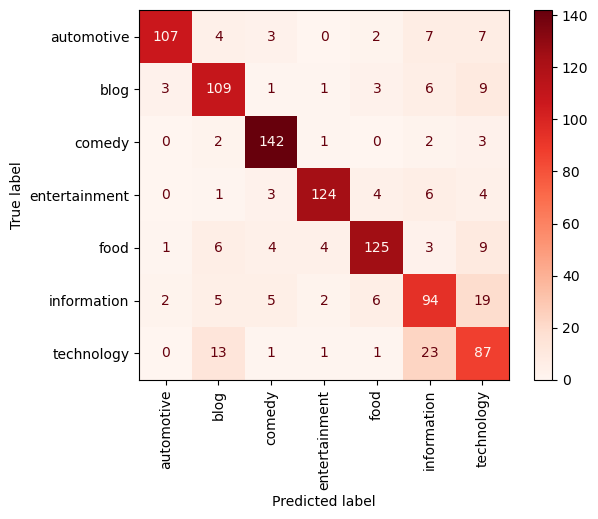

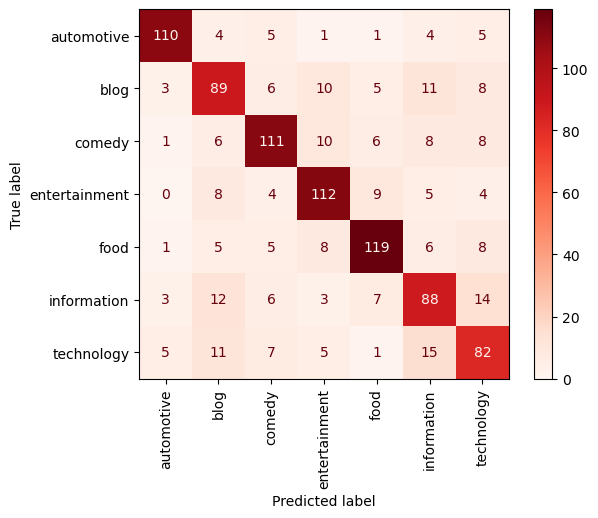

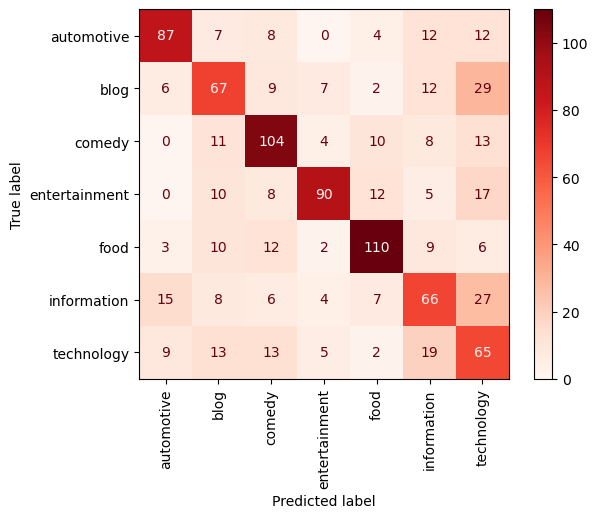

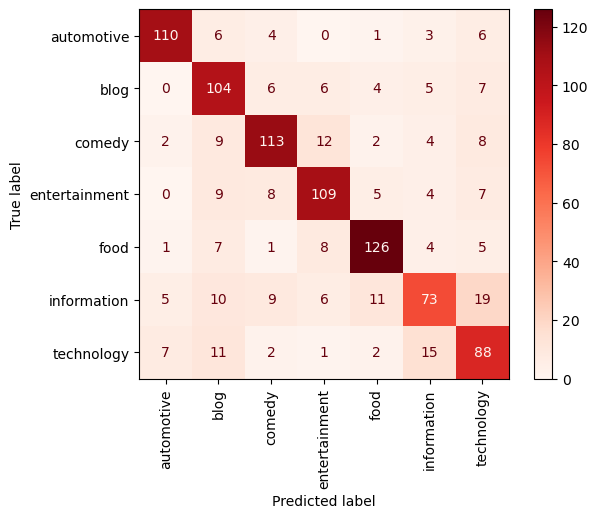

In [75]:
cm_dict = {}

for key, value in model_dict.items():
    pred = value.predict(test_generator)
    predictions = np.argmax(pred, axis=1)
    cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)
    acc = round(accuracy_score(np.argmax(y_test, axis=1), predictions)*100,2)
    print(f"Accuracy of {acc}%")
    cm_display = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
    cm_display.plot(cmap="Reds", xticks_rotation=90)
    cm_dict[key] = cm

C:\Users\Dominik Hahn\AppData\Local\Temp\ipykernel_7236\962454562.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(le.classes_, rotation=90)


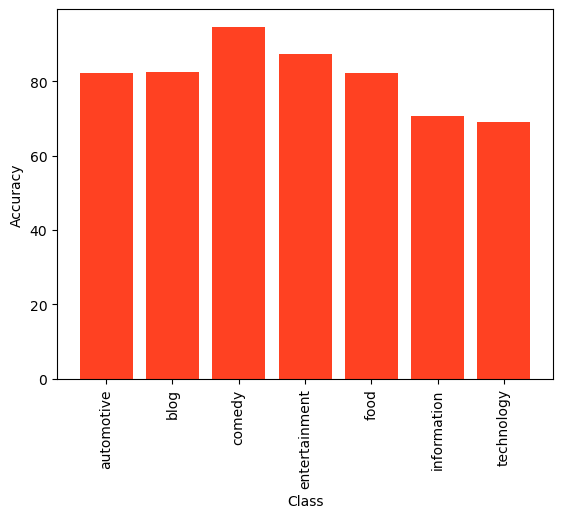

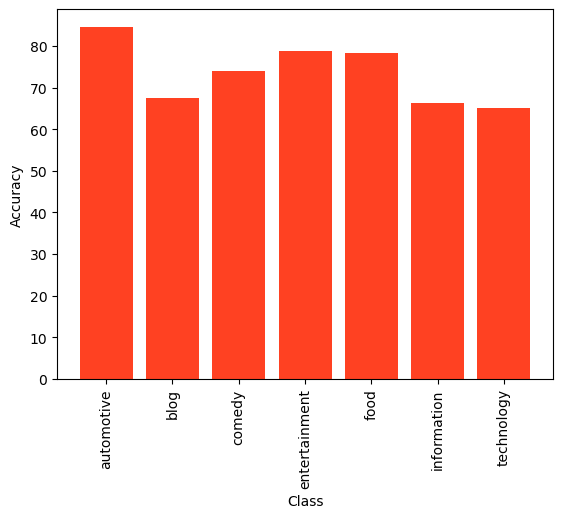

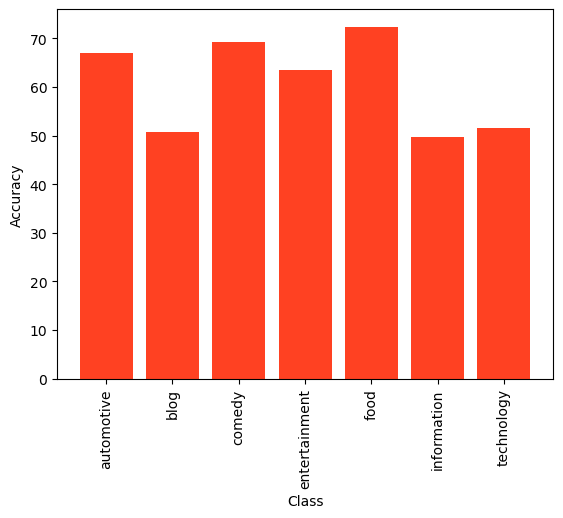

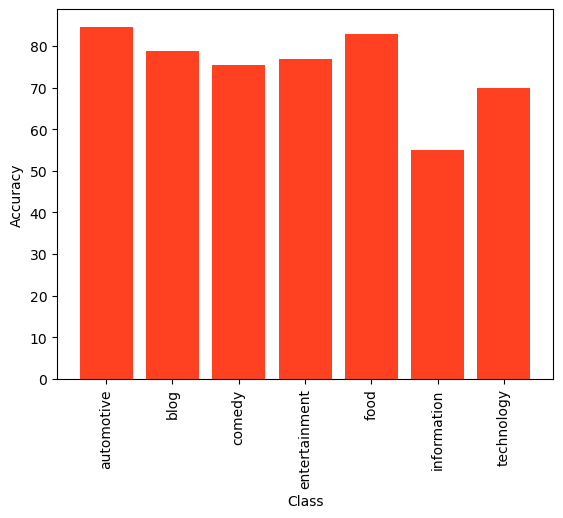

In [93]:
for key, value in model_dict.items():

    cm = cm_dict[key]

    class_count = cm.sum(axis=1)
    class_accuracy = np.diag(cm) / class_count
    class_accuracy = [round(class_acc * 100, 2) for class_acc in class_accuracy]
    accuracy_dict[key] = [round(np.mean(class_accuracy),2)]
    accuracy_dict[key].append(round(np.sum(np.array(class_accuracy) * class_count) / np.sum(class_count),2))

    plot_class_accuracies(class_accuracy)

In [97]:
with open('accuracies_v2.pkl', 'wb') as f:
    pickle.dump(accuracy_dict, f)

# XAI

In [27]:
for key, value in model_dict.items():
    flatten = Flatten()(value.output)
    if key == "vgg_16" or key == "xception":
        dense1 = Dense(128, activation="relu")(flatten)
    else:
        dense1 = Dense(64, activation="relu")(flatten)
    batch_norm1 = BatchNormalization()(dense1)
    dropout1 = Dropout(dropout)(batch_norm1)
    dense2 = Dense(64, activation="relu")(dropout1)
    batch_norm2 = BatchNormalization()(dense2)
    dropout2 = Dropout(dropout)(batch_norm2)
    if key == 'inception_v3':
        output = Dense(len(le.classes_), activation="softmax")(dense2)
    else:
        output = Dense(len(le.classes_), activation="sigmoid")(dense2)
    model= Model(inputs=value.input, outputs=output)
    model_dict[key] = model

In [31]:
font = ImageFont.truetype("arial.ttf", 40)
output_dir = "results/Model/v2"

for model_name, model in model_dict.items():
    output_path = os.path.join(output_dir, model_name + "_model.png")
    visualkeras.layered_view(model, to_file=output_path, legend=True, font=font)
    print(f"Visualisierung für {model_name} erstellt und unter {output_path} gespeichert.")

model_name="custom"
output_path = os.path.join(output_dir, model_name + "_model.png")
visualkeras.layered_view(custom_model, to_file=output_path, legend=True, font=font)
print(f"Visualisierung für {model_name} erstellt und unter {output_path} gespeichert.")

Visualisierung für vgg_16 erstellt und unter results/Model/v2\vgg_16_model.png gespeichert.
Visualisierung für inception_v3 erstellt und unter results/Model/v2\inception_v3_model.png gespeichert.
Visualisierung für resnet_50 erstellt und unter results/Model/v2\resnet_50_model.png gespeichert.
Visualisierung für xception erstellt und unter results/Model/v2\xception_model.png gespeichert.
Visualisierung für custom erstellt und unter results/Model/v2\custom_model.png gespeichert.


In [36]:
for key, value in model_dict.items():
    value.save(f"./saved_models/v2/{key}.h5")

In [25]:
# Images for Dashboard (retrain for Grad and Lime)
image_dirs = [
    "./data/images/NowThis News/t-lMIGV-dUI.jpg",
    "./data/images/The Grand Tour/IDtHjIe13aU.jpg",
    "./data/images/Fireship/ZtyMdRzvi0w.jpg",
    "./data/images/The Office/8GxqvnQyaxs.jpg",
    "./data/images/JRE Clips/VFns39RXPrU.jpg"
]

labels = ["information", "automotive", "technology", "comedy", "blog"]

In [26]:
custom_xai = custom_model
vgg_16_xai = model_vgg_16
inception_xai = model_inception_v3
resnet_xai = model_resnet_50
xception_xai = model_xception

# Grad Cam

In [27]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_input
from tensorflow.keras.applications.inception_v3 import  preprocess_input as inception_input
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_input
from tensorflow.keras.applications.xception import  preprocess_input as xception_input

def preprocess_img(img_dir, model_name):
    img = image_method.load_img(img_dir, target_size=(224, 224))
    img = image_method.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    if model_name == 'vgg16':
        return vgg16_input(img)
    elif model_name == 'inception_v3':
        return inception_input(img)
    elif model_name == 'resnet_50':
        return resnet_input(img)
    elif model_name == 'xception':
        return xception_input(img)
    else:
        return img / 255   

def grad_cam(img_array, model, layer_name):
    grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        layer_output, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    gradients = tape.gradient(loss, layer_output)[0]
    casted_layer_output = tf.cast(layer_output > 0, "float32")
    casted_gradients = tf.cast(gradients > 0, "float32")
    guided_gradients = casted_layer_output * casted_gradients * gradients

    # Remove unnecessary dims
    layer_output = layer_output[0]

    weights = tf.reduce_mean(guided_gradients, axis=(0,1))
    grad_cam = tf.reduce_sum(tf.multiply(weights, layer_output), axis=-1)

    width, height = img_array.shape[2], img_array.shape[1]
    heatmap = cv2.resize(grad_cam.numpy(), (width, height))
    counter = heatmap - np.min(heatmap)
    denominator = (heatmap.max() - heatmap.min())

    scaled_heatmap = counter / denominator
    
    return scaled_heatmap

def display_grad_cam(img, heatmap):
    img = image_method.img_to_array(img)
    heatmap = np.uint8(255*heatmap)
    
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = image_method.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image_method.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = image_method.array_to_img(superimposed_img)
    
    return superimposed_img


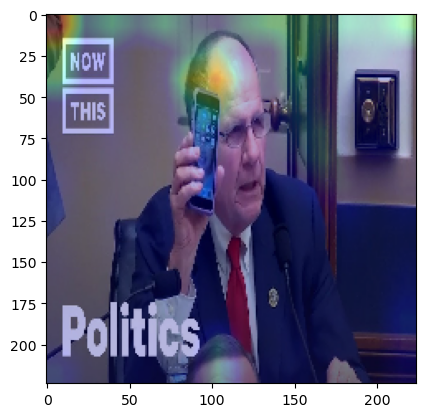

In [28]:
img_value = image_dirs[0]

img_array = preprocess_img(img_value, 'vgg16')
heatmap = grad_cam(img_array, vgg_16_xai, "block5_conv3")

img = image_method.load_img(img_value, target_size=(224, 224))
img = image_method.img_to_array(img)

plt.imshow(display_grad_cam(img, heatmap))

# Custom Model

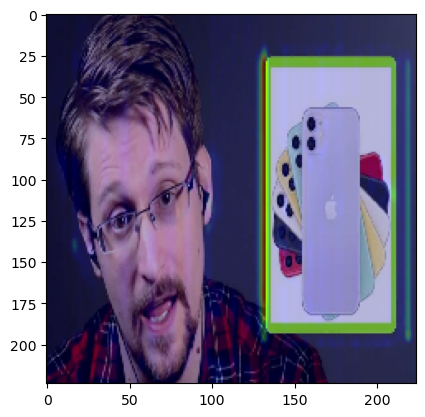

In [33]:
initial_img = image_dirs[4]
img_array = preprocess_img(initial_img, 'custom')
heatmap = grad_cam(img_array, custom_model, "last_conv")
img = image_method.load_img(initial_img, target_size=(224, 224))
img = image_method.img_to_array(img)

plt.imshow(display_grad_cam(img, heatmap))